In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/masinsko/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/masinsko


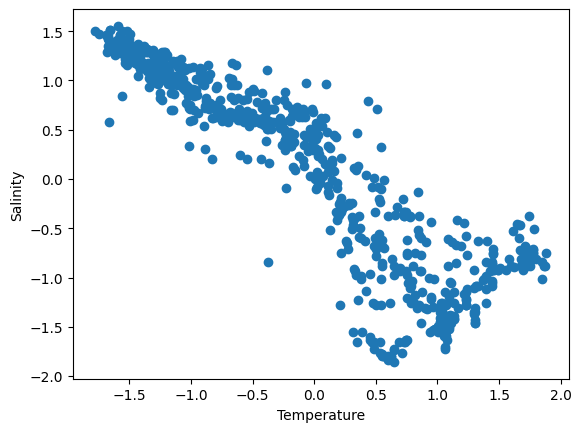

Epoch: 10/150| Avg loss: 0.16264
Epoch: 20/150| Avg loss: 0.14790
Epoch: 30/150| Avg loss: 0.13697
Epoch: 40/150| Avg loss: 0.12961
Epoch: 50/150| Avg loss: 0.12508
Epoch: 60/150| Avg loss: 0.12250
Epoch: 70/150| Avg loss: 0.12111
Epoch: 80/150| Avg loss: 0.12038
Epoch: 90/150| Avg loss: 0.12000
Epoch: 100/150| Avg loss: 0.11979
Epoch: 110/150| Avg loss: 0.11966
Epoch: 120/150| Avg loss: 0.11958
Epoch: 130/150| Avg loss: 0.11952
Epoch: 140/150| Avg loss: 0.11948
Epoch: 150/150| Avg loss: 0.11946
w = [-1.5676061  -0.98231936  0.53691745  0.75619286 -0.07089145 -0.13081987], bias = 0.1833011955022812


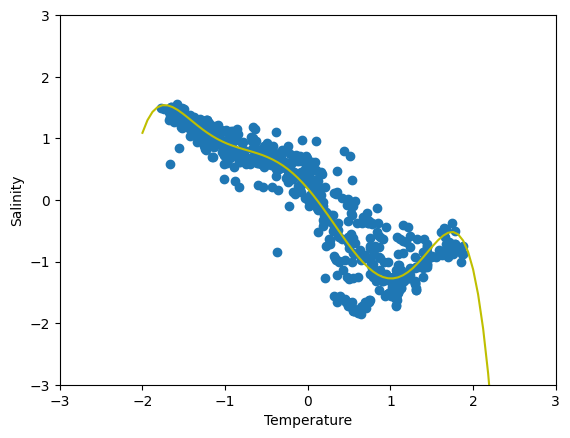

In [ ]:
def create_feature_matrix(x, nb_features):
    tmp_features = []
    for deg in range(1, nb_features+1):
        tmp_features.append(np.power(x, deg))
    return np.column_stack(tmp_features)

filename = 'bottle.csv'
all_data = pd.read_csv(filename, nrows=700, usecols=['T_degC','Salnty'], dtype='float32')
all_data_wn = all_data.dropna(ignore_index=True)
data = dict()
data['x'] = all_data_wn['T_degC']
data['y'] = all_data_wn['Salnty']

nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

nb_features = 6
data['x'] = create_feature_matrix(data['x'], nb_features)

plt.scatter(data['x'][:, 0], data['y'])
plt.xlabel('Temperature')
plt.ylabel('Salinity')
plt.show()

# model i parametri
w = tf.Variable(tf.zeros(nb_features))
b = tf.Variable(0.0)

learning_rate = 0.01
batch_size = 32
nb_epochs = 150

def pred(x, w, b):
    w_col = tf.reshape(w, (nb_features, 1))
    hyp = tf.add(tf.matmul(x, w_col), b)
    return hyp

# funkcija troska i optimizacija
def loss(x, y, w, b, reg=None):
    prediction = pred(x, w, b)
    y_col = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_col))

    # regularizacija
    lmbd = 0.01
    if reg == 'l1':
        l1_reg = lmbd * tf.reduce_mean(tf.abs(w))
        loss = tf.add(mse, l1_reg)
    elif reg == 'l2':
        l2_reg = lmbd * tf.reduce_mean(tf.square(w))
        loss = tf.add(mse, l2_reg)
    else:
        loss = mse

    return loss

# gradijent
def calc_grad(x, y, w, b):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, w, b, reg=None)
    w_grad, b_grad = tape.gradient(loss_val, [w, b])
    return w_grad, b_grad, loss_val

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def train_step(x, y, w, b):
    w_grad, b_grad, loss_val = calc_grad(x, y, w, b)
    adam.apply_gradients(zip([w_grad, b_grad], [w, b]))
    return loss_val

for epoch in range(nb_epochs):
    # mini-batch
    epoch_loss = 0
    for i in range(0, nb_samples, batch_size):
        x_batch = data['x'][i:i+batch_size]
        y_batch = data['y'][i:i+batch_size]
        curr_loss = train_step(x_batch, y_batch, w, b)
        epoch_loss += curr_loss

    epoch_loss /= (nb_samples // batch_size)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{nb_epochs}| Avg loss: {epoch_loss:.5f}')

# plotujemo finalnu vrednost parametara
print(f'w = {w.numpy()}, bias = {b.numpy()}')

# finalni model
xs = create_feature_matrix(np.linspace(-2, 4, 100, dtype='float32'), nb_features)
hyp_val = pred(xs, w, b)
plt.scatter(data['x'][:, 0], data['y'])
plt.xlabel('Temperature')
plt.ylabel('Salinity')
plt.plot(xs[:, 0].tolist(), hyp_val.numpy().tolist(), color='y')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()
